In [2]:
# Cell 1: Load and track CSV data
!pip install pandas requests
import pandas as pd
import requests
import json
from datetime import datetime
from reprolab.archive_file import save_compact, read_compact, persistio

@persistio
def get_books():
    books_csv = pd.read_csv('books.csv')
    return books_csv


In [3]:
for col in books_csv.select_dtypes(include='object').columns:
    books_csv[col] = books_csv[col].str.capitalize()
books_csv.head()

,title,author,publication_year
0,The great gatsby,F. scott fitzgerald,1925
1,1984,George orwell,1949
2,To kill a mockingbird,Harper lee,1960


In [4]:
# Cell 2: Fetch and track API data
import requests
import pandas as pd

def get_book_details(title):
    url = f"https://openlibrary.org/search.json?title={title}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data['docs']:
            book = data['docs'][0]
            return {
                'isbn': book.get('isbn', ['N/A'])[0],
                'page_count': book.get('number_of_pages_median', 0),
                'first_publish': book.get('first_publish_year', None)
            }
    return {'isbn': 'N/A', 'page_count': 0, 'first_publish': None}

api_data = books_csv['title'].apply(get_book_details)
api_df = pd.DataFrame(api_data.tolist())
print("\nAPI fetched data:")
print(api_df.head())


# Some transformations
api_df = api_df.iloc[:-1]




API fetched data:
  isbn  page_count  first_publish
0  N/A           0           1920
1  N/A           0           2003
2  N/A           0           1960


In [5]:
# Cell 3: Create and track dictionary data
book_categories = {
    "The Great Gatsby": {"genre": "Fiction", "rating": 4.5, "price": 12.99},
    "1984": {"genre": "Dystopian", "rating": 4.8, "price": 15.99},
    "To Kill a Mockingbird": {"genre": "Literary Fiction", "rating": 4.7, "price": 14.99}
}

category_df = pd.DataFrame.from_dict(book_categories, orient='index')
category_df.index.name = 'title'
category_df = category_df.reset_index()
print("\nDictionary data:")
print(category_df.head())

# No new inputs originating from ths cell



Dictionary data:
                   title             genre  rating  price
0       The Great Gatsby           Fiction     4.5  12.99
1                   1984         Dystopian     4.8  15.99
2  To Kill a Mockingbird  Literary Fiction     4.7  14.99


In [6]:
# Cell 4: Merge all data sources and track intermediate result
combined_df = pd.concat([books_csv, api_df], axis=1)
final_df = pd.merge(combined_df, category_df, on='title', how='left')
final_df

,title,author,publication_year,isbn,page_count,first_publish,genre,rating,price
0,The great gatsby,F. scott fitzgerald,1925,N/A,0.0,1920.0,NaN,NaN,NaN
1,1984,George orwell,1949,N/A,0.0,2003.0,Dystopian,4.8,15.99
2,To kill a mockingbird,Harper lee,1960,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Cell 5: Perform transformations
current_year = datetime.now().year
final_df['book_age'] = current_year - final_df['publication_year']
final_df['price_per_page'] = final_df['price'] / final_df['page_count'].replace(0, 1)

def rating_category(rating):
    if rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Good'
    else:
        return 'Average'

final_df['rating_category'] = final_df['rating'].apply(rating_category)
final_df['rating_category']

0      Average
1    Excellent
2      Average
Name: rating_category, dtype: object


Dataset Statistics:
       publication_year  page_count  first_publish  rating  price    book_age  \
count          3.000000         2.0       2.000000     1.0   1.00    3.000000   
mean        1944.666667         0.0    1961.500000     4.8  15.99   80.333333   
std           17.897858         0.0      58.689863     NaN    NaN   17.897858   
min         1925.000000         0.0    1920.000000     4.8  15.99   65.000000   
25%         1937.000000         0.0    1940.750000     4.8  15.99   70.500000   
50%         1949.000000         0.0    1961.500000     4.8  15.99   76.000000   
75%         1954.500000         0.0    1982.250000     4.8  15.99   88.000000   
max         1960.000000         0.0    2003.000000     4.8  15.99  100.000000   

       price_per_page  
count            1.00  
mean            15.99  
std               NaN  
min             15.99  
25%             15.99  
50%             15.99  
75%             15.99  
max             15.99  

Genre Summary:
           rating

<Figure size 1000x600 with 0 Axes>

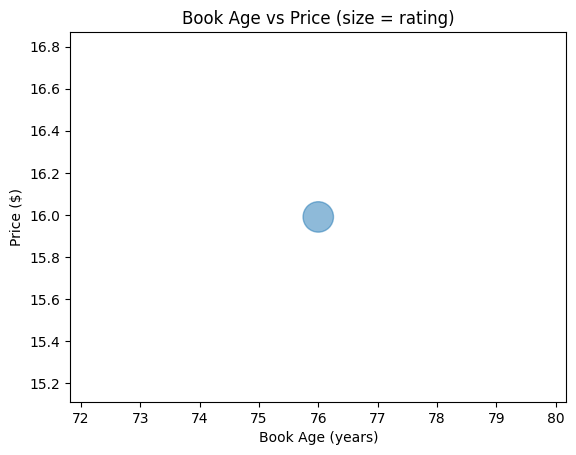

In [8]:
!pip install matplotlib
# Cell 7: Final analysis and visualization
print("\nDataset Statistics:")
print(final_df.describe())

genre_summary = final_df.groupby('genre').agg({
    'rating': 'mean',
    'price': 'mean',
    'page_count': 'mean'
}).round(2)

print("\nGenre Summary:")
print(genre_summary)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
final_df.plot(kind='scatter', x='book_age', y='price', s=final_df['rating']*100, alpha=0.5)
plt.title('Book Age vs Price (size = rating)')
plt.xlabel('Book Age (years)')
plt.ylabel('Price ($)')
plt.show()